## Introduction

In this tutorial, we will run a quicklook spectrotemporal analysis of a NICER observation of one epoch of the 2018 outburst of the accreting black hole MAXI 1820+070, largely reproducing the results from, e.g., [Wang et al. 2021](https://ui.adsabs.harvard.edu/abs/2021ApJ...910L...3W/abstract), [De Marco et al. 2021](https://ui.adsabs.harvard.edu/abs/2021A%26A...654A..14D/abstract). We will not give a scientific interpretation, just pure exploration.

The dataset used for the analysis can be downloaded [on Zenodo](https://zenodo.org/records/10683101). 

DISCLAIMER: this dataset was downloaded from the NICER archive and only run through `barycorr` to refer the photon arrival times to the solar system barycenter. We did not run the official NICER pipeline on these data, and some of the features appearing in the power spectrum are instrumental artifacts. Data are not science-ready and only good for demonstration purposes. For more information (thanks Paul Ray and Sara Motta for discussion): 

+ [Some Notes on Timing Analyses and NICER Data (using also MAXI J1820+070 as an example)](https://heasarc.gsfc.nasa.gov/docs/nicer/data_analysis/workshops/nicer_wkshp_timing_5_4_21.pdf)
+ [NICER Analysis Threads](https://heasarc.gsfc.nasa.gov/docs/nicer/analysis_threads/)

See [Uttley et al. 2014](https://ui.adsabs.harvard.edu/abs/2014A%26ARv..22...72U/abstract), [Bachetti & Huppenkothen 2022](https://ui.adsabs.harvard.edu/abs/2022arXiv220907954B/abstract) for reviews on most statistical concepts and terminology used here.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import black
# Uncomment and run this before releasing a new version of the docs
# import jupyter_black

# jupyter_black.load(
#     lab=False,
#     line_length=100,
#     verbosity="DEBUG",
#     target_version=black.TargetVersion.PY310,
# )

import os
import copy
import glob
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.table import Table
from astropy.modeling import models

from stingray.gti import create_gti_from_condition, gti_border_bins, time_intervals_from_gtis, cross_two_gtis
from stingray.utils import show_progress
from stingray.fourier import avg_cs_from_events, avg_pds_from_events, poisson_level, get_average_ctrate
from stingray import AveragedPowerspectrum, AveragedCrossspectrum, EventList
from stingray.modeling.parameterestimation import PSDLogLikelihood

mpl.rcParams['agg.path.chunksize'] = 10000

os.environ["HEADASNOQUERY"] = ""
os.environ["HEADASPROMPT"] = "/dev/null"


## Data loading and cleanup.

Let us take a look at the light curve. We load the NICER event list into a `stingray.EventList` object, and create a `stingray.Lightcurve` from it. Note that, for NICER, it is important to know how many detectors were on during the observation. In this tutorial, we make a rough check of how many detectors were on during the observation. In some cases, the number of detectors might _change_ during the observation. The user is encouraged to plot the `events.det_id` attribute (that gets set thanks to the `additional_columns` instruction below) and check the header of the event file for possible detectors that were switched off.

In [2]:
# This dataset can be downloaded from the NICER archive at the HEASARC.
# We do not include it because of the large size.
fname = "ni1200120106_0mpu7_cl_bary.evt.gz"
# Here we are also saving the information about the detector
events = EventList.read(fname, "hea", additional_columns=["DET_ID"])
events.fname = fname

<Axes: xlabel='Time (s)', ylabel='counts'>

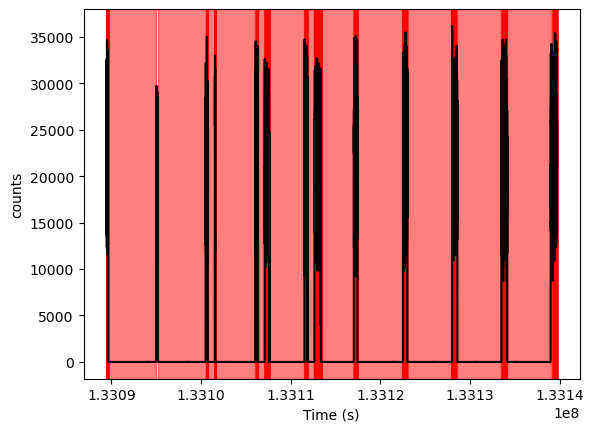

In [3]:
# Create light curve and apply GTIs
lc_raw = events.to_lc(dt=1)

lc_raw.plot()

The red areas in the midst of the "good" data intervals are actually small intervals of missing data. For example,

<Axes: xlabel='Time (s)', ylabel='counts'>

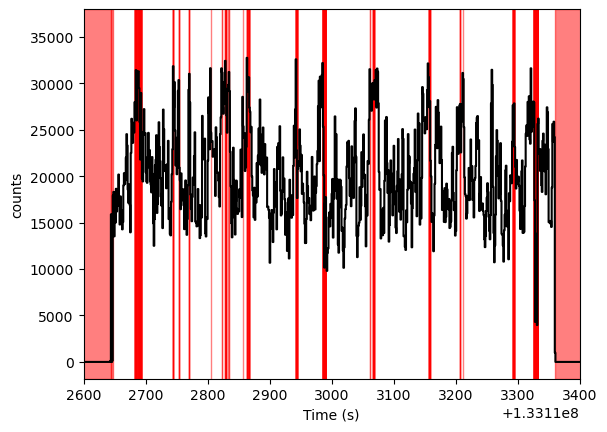

In [4]:
lc_raw.plot(axis_limits=[1.331126e8, 1.331134e8, None, None])

Let us get some statistics on these bad time intervals, in particular the very small ones.

Total exposure: 5438.068227797747
Total BTI length: 44846.231474906206
Total BTI length (short BTIs): 33.45650801062584


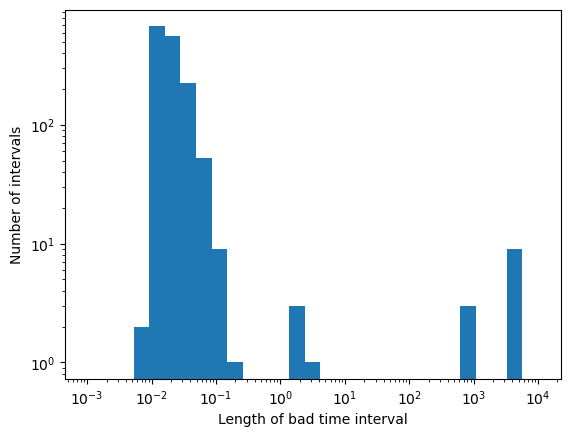

In [5]:
from stingray.gti import get_gti_lengths, get_btis, get_total_gti_length

gti_lengths = get_gti_lengths(events.gti)
btis = get_btis(events.gti)
bti_lengths = get_gti_lengths(btis)

plt.hist(bti_lengths, bins=np.geomspace(1e-3, 10000, 30))
plt.xlabel("Length of bad time interval")
plt.ylabel("Number of intervals")
plt.loglog()

print(f"Total exposure: {get_total_gti_length(events.gti)}")
print(f"Total BTI length: {get_total_gti_length(btis)}")
print(f"Total BTI length (short BTIs): {get_total_gti_length(btis[bti_lengths < 1])}")

These short bad intervals $\lesssim 1\,$s represent a very small fraction of the total data, and can be filled with simulated data, without altering too much the statistical properties of the data themselves.

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 168.52it/s]


<Axes: xlabel='Time (s)', ylabel='counts'>

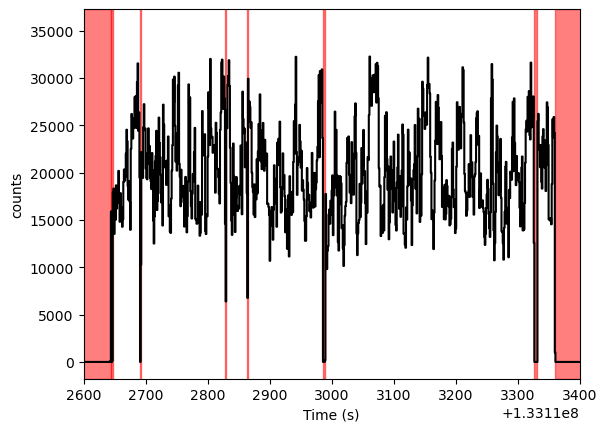

In [6]:
# max_length is the longest bad time interval in seconds we want to fill with simulated data.
# The buffer size is the region (in time array size, not seconds!) around the bad time interval that we use to
# extract the distribution of the data to simulate. This can take a while
ev_filled = events.fill_bad_time_intervals(max_length=1)
lc_filled = ev_filled.to_lc(dt=1)
lc_filled.plot(axis_limits=[1.331126e8, 1.331134e8, None, None])

Let us compare the raw light curve with the simulated data in the same interval above

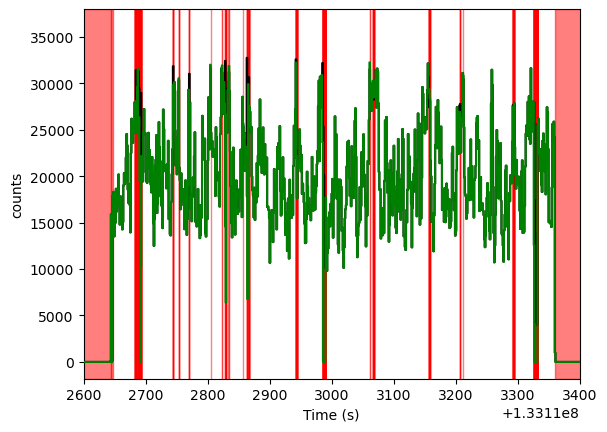

In [7]:
ax = lc_raw.plot(axis_limits=[1.331126e8, 1.331134e8, None, None])
ax.plot(lc_filled.time, lc_filled.counts, color="green", drawstyle="steps-mid", zorder=20)

The light curve seems reasonably clean, with no need for further cleaning. Otherwise, we would have to filter out, e.g. flares or intervals with zero counts, doing something along the lines of:

```
new_gti = create_gti_from_condition(lc_raw.time, lc_raw.counts > 0, safe_interval=1)
lc = copy.deepcopy(lc_raw)
lc.gti = new_gti
lc.apply_gtis()

plt.figure()
plt.plot(lc_raw.time, lc_raw.counts, color="grey", alpha=0.5, label="Raw")
plt.plot(lc.time, lc.counts, color="k", label="Cleaned")
plt.title("Light curve")
plt.xlabel(f"Time (s from {events.mjdref})")
plt.ylabel(f"Counts/bin")
plt.legend();

events.gti = new_gti
```

In [8]:
events = ev_filled

## Hardness-intensity diagram

Just for the sake of consistency, we verify that the hardness-intensity diagram of the source tells the same story as the analysis done by Wang+2021. This observation was marked as Epoch 0 there, well into the hard state

In [9]:
ndet = len(set(events.det_id))
print(f"NICER was using {ndet} detectors")

NICER was using 52 detectors


In [10]:
# Using the same intervals as the Wang+ paper.
# We use a segment size of 256 seconds, but we could make different choices depending
# on the quality of the dataset and the count rate.

h_starts, h_stops, colors, color_errs = events.get_color_evolution(
    energy_ranges=[[2, 4], [4, 12]], segment_size=256
)
i_starts, i_stops, intensity, intensity_errs = events.get_intensity_evolution(
    energy_range=[0.4, 12], segment_size=256
)

We compare the colors with the hardness-intensity diagram from [Wang et al. 2021](https://ui.adsabs.harvard.edu/abs/2021ApJ...910L...3W/abstract). The grey and red data plotted here were kindly provided by Jingyi Wang. The red dots indicate the points in the Wang plot corresponding to this observation. The difference in scatter is probably due to slightly different intervals being used in the analysis. Epoch 0 data are rescaled for 50 PCUs (as different observations had different number of working PCUs), while our data and the input data set from the complete outburst are rescaled to 52. We rescale everything to 50 for consistency with Wang+2021


In [11]:
wang_data = Table.read("wang_data.csv", names=["H", "I"])
epoch0_wang_data = Table.read("epoch_0_data.csv", names=["H", "I"])

epoch_zero_i = epoch0_wang_data["I"]
epoch_zero_h = epoch0_wang_data["H"]

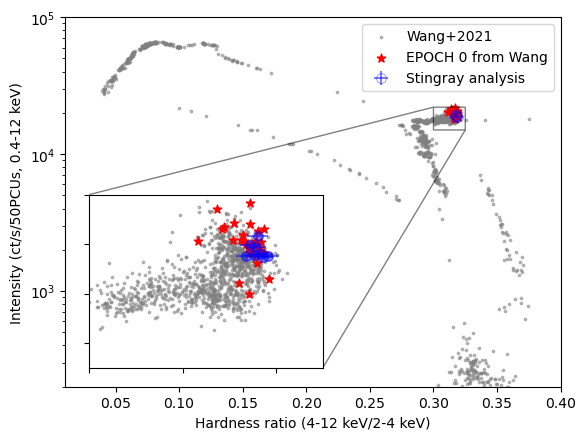

In [12]:
fig, ax = plt.subplots()
(plotline, _, _) = ax.errorbar(
    colors,
    intensity / ndet * 50,
    yerr=intensity_errs / ndet * 50,
    xerr=color_errs,
    fmt="o",
    color="b",
    alpha=0.5,
    markersize=7,
    label="Stingray analysis",
    zorder=10,
)
plotline.set_markerfacecolor("none")
plotline.set_markeredgewidth(0.5)
ax.scatter(
    wang_data["H"],
    wang_data["I"] / 52 * 50,
    alpha=0.5,
    color="grey",
    zorder=1,
    s=3,
    label="Wang+2021",
)
ax.set_xlim([0.01, 0.4])
ax.set_ylim([2e2, 1e5])
ax.set_xlabel("Hardness ratio (4-12 keV/2-4 keV)")
ax.set_ylabel("Intensity (ct/s/50PCUs, 0.4-12 keV)")
ax.semilogy()
ax.scatter(
    epoch_zero_h, epoch_zero_i, marker="*", color="red", zorder=2, s=40, label="EPOCH 0 from Wang"
)

axins = ax.inset_axes(
    [0.05, 0.05, 0.47, 0.47], xlim=(0.30, 0.325), ylim=(1.5e4, 2.2e4), xticklabels=[], yticklabels=[]
)

axins.scatter(wang_data["H"], wang_data["I"] / 52 * 50, alpha=0.5, color="grey", zorder=1, s=3)
axins.errorbar(
    colors,
    intensity / ndet * 52,
    yerr=intensity_errs / ndet * 52,
    xerr=color_errs,
    fmt="o",
    color="b",
    alpha=0.5,
    markersize=7,
    zorder=10,
)
axins.scatter(epoch_zero_h, epoch_zero_i, marker="*", color="red", zorder=2, s=40)

ax.indicate_inset_zoom(axins, edgecolor="black")
ax.legend(loc="upper right")

## Periodogram and cross spectrum

Let us now take a look at the periodogram and the cross spectrum. 
The periodogram will be obtained with Bartlett's method: splitting the light curve into equal-length segments, calculating the periodogram in each, and then averaging them into the final periodogram.

We will use the fractional rms normalization (sometimes referred to as the _Belloni_, or _Miyamoto_, normalization, from the papers [Belloni & Hasinger 1990](https://ui.adsabs.harvard.edu/abs/1990A%26A...230..103B/abstract), [Miyamoto et al. 1992](https://ui.adsabs.harvard.edu/abs/1992ApJ...391L..21M/abstract)). The background contribution is negligible and will be ignored.

Note: since the fractional rms normalization uses the mean count rate, the final result changes slightly if the normalization is applied in the single periodograms from each light curve segment, with the count rate of each chunk, or on the averaged periodogram, using the average count rate of the full light curve. We choose the second option (note the `use_common_mean=True`).

We will first plot the periodogram as is, in units of $(\mathrm{rms/mean)^2\,Hz^{-1}}$.

Then, from the periodogram, we will subtract the theoretical Poisson noise level of $2/\mu$, where $\mu$ is the mean count rate in the observation, and we will multiply the powers by the frequency, to have the periodogram in units of $(\mathrm{rms/mean)^2}$. 

In both cases, we will rebin the periodogram geometrically, averaging more bins at larger frequencies, in order to lower the noise level.

In [13]:
# Calculate the periodogram in fractional rms normalization.
# Length in seconds of each light curve segment
segment_size = 2
# Sampling time of the light curve: 1ms, this will give a Nyquist
# frequency of 0.5 / dt = 500 Hz.
dt = 0.002
# Fractional rms normalization
norm = "frac"

pds = AveragedPowerspectrum.from_events(
    events, segment_size=segment_size, dt=dt, norm=norm, use_common_mean=True
)

# Calculate the mean count rate
ctrate = get_average_ctrate(events.time, events.gti, segment_size)
# Calculate the Poisson noise level
noise = poisson_level(norm, meanrate=ctrate)

# Rebin the periodogam
pds_reb = pds.rebin_log(0.02)

2696it [00:01, 2276.82it/s]


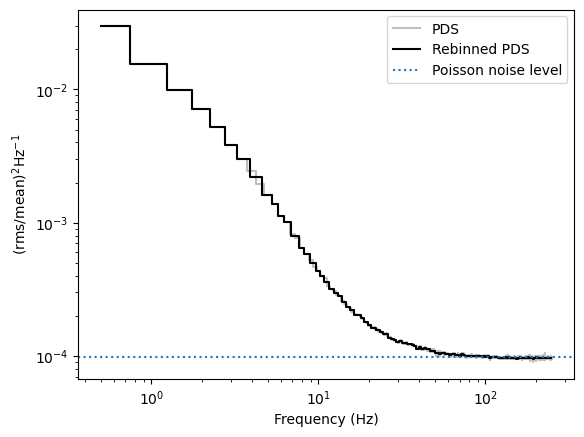

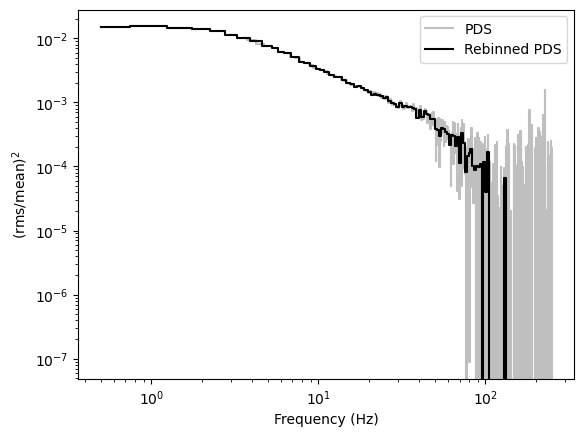

In [14]:
plt.figure()

plt.plot(pds.freq, pds.power, drawstyle="steps-mid", color="grey", alpha=0.5, label="PDS")
plt.plot(pds_reb.freq, pds_reb.power, drawstyle="steps-mid", color="k", label="Rebinned PDS")
plt.axhline(noise, ls=":", label="Poisson noise level")
plt.loglog()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\mathrm{(rms / mean)^2 Hz^{-1}}$")
plt.legend()

plt.figure()
plt.plot(
    pds.freq,
    (pds.power - noise) * pds.freq,
    drawstyle="steps-mid",
    color="grey",
    alpha=0.5,
    label="PDS",
)
plt.plot(
    pds_reb.freq,
    (pds_reb.power - noise) * pds_reb.freq,
    drawstyle="steps-mid",
    color="k",
    label="Rebinned PDS",
)
plt.loglog()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\mathrm{(rms / mean)^2}$")
plt.legend();

We will now do the same with the cross spectrum between the bands 0.5-1 keV and 1.5-3 keV.

In this case, there is no need to subtract the Poisson noise level, as it is zero in the cross spectrum, provided that the energy bands do not overlap.

In [15]:
ref_band = [1.5, 3]
sub_band = [0.5, 1]
events_ref = events.filter_energy_range(ref_band)
events_sub = events.filter_energy_range(sub_band)

cs = AveragedCrossspectrum.from_events(
    events_sub, events_ref, segment_size=2, dt=dt, norm=norm
)
cs_reb = cs.rebin_log(0.04)

2696it [00:00, 2810.51it/s]


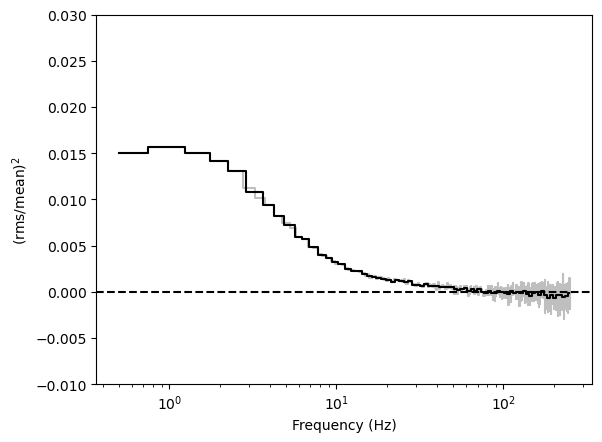

In [16]:
plt.figure()
plt.plot(cs.freq, cs.power.real * cs.freq, drawstyle="steps-mid", color="grey", alpha=0.5)
plt.plot(cs_reb.freq, cs_reb.power.real * cs_reb.freq, drawstyle="steps-mid", color="k")
plt.axhline(0, ls="--", color="k")
plt.semilogx()
plt.ylim(-0.01, 0.03)
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\mathrm{(rms / mean)^2}$");

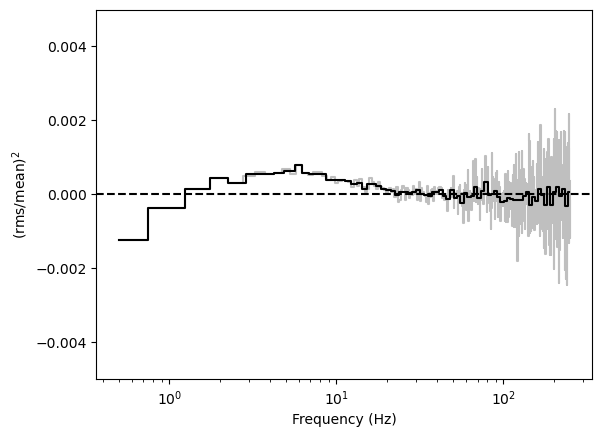

In [17]:
plt.figure()
plt.plot(cs.freq, cs.power.imag * cs.freq, drawstyle="steps-mid", color="grey", alpha=0.5)
plt.plot(cs_reb.freq, cs_reb.power.imag * cs_reb.freq, drawstyle="steps-mid", color="k")
plt.semilogx()
plt.ylim(-0.005, 0.005)
plt.axhline(0, ls="--", color="k")
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\mathrm{(rms / mean)^2}$");

## Periodogram modeling

This periodogram has a number of broad components, that can be approximated by Lorentzian curves.
Let us try to model it.


In [18]:
pds = AveragedPowerspectrum.from_events(events, segment_size=segment_size, dt=dt, norm="leahy")
pds_reb = pds.rebin_log(0.02)

2696it [00:01, 2244.27it/s]


We will model the periodogram using the maximum likelihood estimation from [Barret & Vaughan 2012](https://ui.adsabs.harvard.edu/abs/2012ApJ...746..131B/abstract).

For periodograms averaged over $L$ independent segments and $M$ independent neighbouring frequencies,
$$
\mathcal{L}_\mathrm{avg}(\theta) = -2ML \sum_{j=1}^{N/2} \left\{ \frac{P_j}{S_j(\theta)} + \ln{S_j(\theta) + \left( \frac{1}{ML} - 1 \right)\ln{P_j} + c(2ML) }\right\} \; ,
$$
where $\theta$ are the model parameters, $P_j$ are the periodogram values, $S_j$ the model of the underlying signal, $c(2ML)$ is a factor independent of $P_j$ or $S_j$, and thus unimportant to the parameter estimation problem considered here (it only scales the likelihood, but does not change its shape). 

For non-uniformly binned periodograms, the factor $ML$ should go inside the sum:
$$
\mathcal{L}_\mathrm{avg}(\theta) = -2\sum_{j=1}^{N/2} M_j L_j \left\{ \frac{P_j}{S_j(\theta)} + \ln{S_j(\theta) + \left( \frac{1}{ M_j L_j } - 1 \right)\ln{P_j} + c(2 M_j L_j ) }\right\} 
$$

This is the formula that we will apply here.

Let us now create an initial model that more or less describes the periodogram

(0.0, 329.83520516072514)

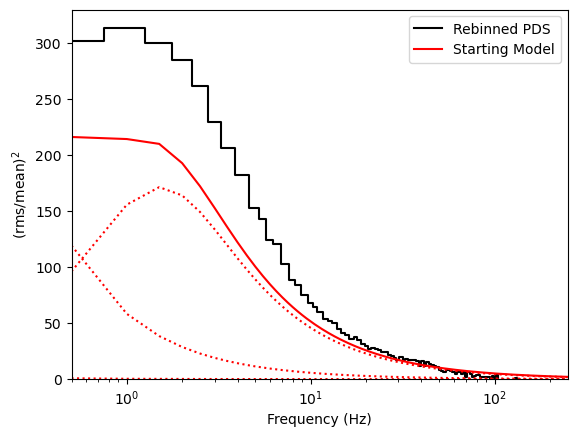

In [19]:
fit_model = (
    models.Lorentz1D(x_0=0.02, fwhm=0.15, amplitude=10000)
    + models.Lorentz1D(x_0=0.1, fwhm=0.1, amplitude=100)
    + models.Lorentz1D(x_0=0.2, fwhm=3, amplitude=200)
)

plt.figure()
plt.plot(
    pds_reb.freq,
    (pds_reb.power - 2) * pds_reb.freq,
    drawstyle="steps-mid",
    color="k",
    label="Rebinned PDS",
)
plt.plot(pds.freq, fit_model(pds.freq) * pds.freq, color="r", label="Starting Model")
for mod in fit_model:
    plt.plot(pds.freq, mod(pds.freq) * pds.freq, color="r", ls=":")

plt.semilogx()
plt.xlim([pds.freq[0], pds.freq[-1]])
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\mathrm{(rms / mean)^2}$")
plt.legend()
plt.ylim([0, None])

We will now add a constant at the Poisson noise level (2 in Leahy normalization) and fit using the Maximum Likelihood estimation in `stingray`

In [20]:
from stingray.modeling import PSDParEst

fit_model = models.Const1D(amplitude=2) + fit_model

parest = PSDParEst(pds_reb, fitmethod="L-BFGS-B", max_post=False)
loglike = PSDLogLikelihood(pds_reb.freq, pds_reb.power, fit_model, m=pds_reb.m)

res = parest.fit(loglike, fit_model.parameters)

fitmod = res.model

# The Poisson noise level was the first parameter.
poisson = fitmod.parameters[0]
print(res.p_opt)

[1.94651573e+00 1.00110624e+04 6.13286908e-02 1.83706917e-01
 1.00689850e+02 1.14721183e-01 3.97041810e-02 1.97903268e+02
 8.09657793e-01 3.26250129e+00]


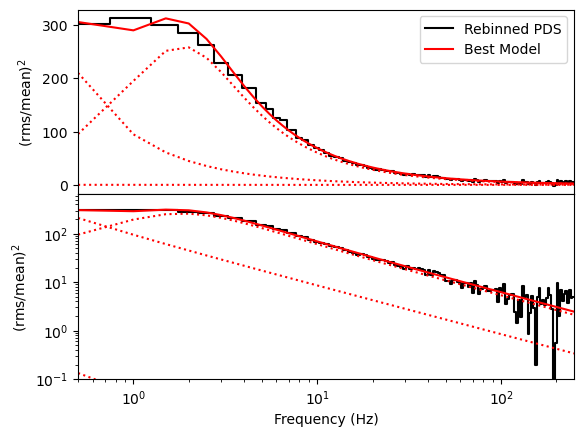

In [21]:
plt.figure()
gs = plt.GridSpec(2, 1, hspace=0)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)

ax0.plot(
    pds_reb.freq,
    (pds_reb.power - poisson) * pds_reb.freq,
    drawstyle="steps-mid",
    color="k",
    label="Rebinned PDS",
)
ax0.plot(pds.freq, (fitmod(pds.freq) - poisson) * pds.freq, color="r", label="Best Model")
for mod in fitmod[1:]:
    ax0.plot(pds.freq, mod(pds.freq) * pds.freq, color="r", ls=":")

ax0.set_xlabel("Frequency (Hz)")
ax0.set_ylabel(r"$\mathrm{(rms / mean)^2}$")
ax0.legend()

ax1.plot(
    pds_reb.freq,
    (pds_reb.power - poisson) * pds_reb.freq,
    drawstyle="steps-mid",
    color="k",
    label="Rebinned PDS",
)
ax1.plot(pds.freq, (fitmod(pds.freq) - poisson) * pds.freq, color="r", label="Best Model")
for mod in fitmod[1:]:
    ax1.plot(pds.freq, mod(pds.freq) * pds.freq, color="r", ls=":")

ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel(r"$\mathrm{(rms / mean)^2}$")
ax1.loglog()
ax1.set_ylim([1e-1, None])
ax1.set_xlim([pds.freq[0], pds.freq[-1]]);

## Power colors

Power colors ([Heil et al. 2015](https://ui.adsabs.harvard.edu/abs/2015MNRAS.448.3339H/abstract)) are an alternative to spectral colors but in the timing regime. The power colors are the ratio of the variability at different timescale, basically they inform us on the slope of the power spectrum in different Fourier frequency regimes. They can be used to understand the spectral state of an accreting source.
Stingray implements power colors both as a standalone function in the `stingray.power_colors` module, to be applied to a single periodogram, and as a method of `DynamicalCrossspectrum` and its children (see the `DynamicalPowerspectrum` tutorial for more information). Here we show one possible way to calculate power colors in the observation we are analyzing.

We use the same frequency edges `[1/256. 1/32, 1/4, 2, 16]` from [Heil et al. 2015](https://ui.adsabs.harvard.edu/abs/2015MNRAS.448.3339H/abstract). The colors are then calculated as 

+ PC1: the ratio of the variances in the intervals 0.25-2 Hz and 0.00390625-0.03125 Hz
+ PC2: the ratio of the variances in the intervals 2-16 Hz and 0.03125-0.25 Hz

In [22]:
from stingray import DynamicalPowerspectrum
from stingray.power_colors import hue_from_power_color, plot_power_colors, plot_hues, DEFAULT_COLOR_CONFIGURATION, power_color

In [23]:
# We use a segment size of 256, corresponding to a minimum frequency of 0.00390625, and a time resolution
# of 1/256 = 0.00390625 seconds, corresponding to a Nyquist frequency of 128 Hz (well above our needs for
# the power colors).

dynps = DynamicalPowerspectrum(events, segment_size=256, sample_time=1 / 256, norm="leahy")

8it [00:00, 17.31it/s]


We slightly rebin the spectrum to gain some signal to noise

In [24]:
dynps_reb = dynps.rebin_by_n_intervals(2, method="average")

We now calculate the power colors and the "hue", or the angle of the measured colors and the point PC1=4.51920 and PC2=0.453724 in the logPC1 vs logPC2 plane.

In [25]:
p1, p1e, p2, p2e = dynps_reb.power_colors(
    freq_edges=[1 / 256, 1 / 32, 0.25, 2, 16], poisson_power=res.p_opt[0]
)

hues = hue_from_power_color(p1, p2)

It is useful to compare power colors with the fractional rms. This can be calculated as

In [26]:
rms, rmse = dynps_reb.compute_rms(1 / 64, 16, poisson_noise_level=res.p_opt[0])

Once the colors are calculated, they can be plotted and compared to the ranges that can be associated with different spectral states. The configuration of the plots can be tweaked by modifying the entries of a configuration dictionary. All defaults are contained in the `DEFAULT_COLOR_CONFIGURATION` and are based on the original paper. The user can start a configuration by using the default, and then tweaking some of the entries. This will almost certainly be needed if the user selects different frequency ranges for the colors.

In [27]:
configuration=DEFAULT_COLOR_CONFIGURATION
configuration

{'center': [4.5192, 0.453724],
 'ref_angle': 2.356194490192345,
 'state_definitions': {'HSS': {'hue_limits': [300, 360], 'color': 'red'},
  'LHS': {'hue_limits': [-20, 140], 'color': 'blue'},
  'HIMS': {'hue_limits': [140, 220], 'color': 'green'},
  'SIMS': {'hue_limits': [220, 300], 'color': 'yellow'}},
 'rms_spans': {-20: [0.3, 0.7],
  0: [0.3, 0.7],
  10: [0.3, 0.6],
  40: [0.25, 0.4],
  100: [0.25, 0.35],
  150: [0.2, 0.3],
  170: [0.0, 0.3],
  200: [0, 0.15],
  370: [0, 0.15]}}

We can now plot the power colors and calculate the hue.

<Axes: xlabel='log$_{10}$PC1', ylabel='log$_{10}$PC2'>

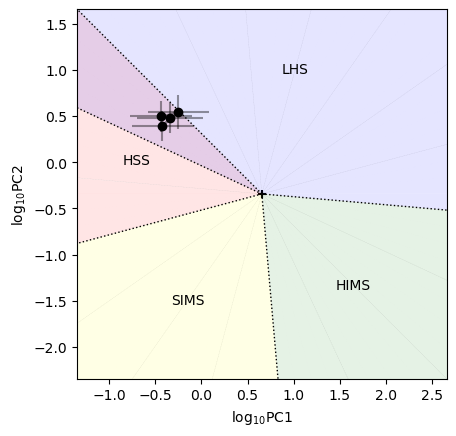

In [28]:
plot_power_colors(p1, p1e, p2, p2e, plot_spans=True, configuration=configuration)

Here, acronyms indicate the spectral state (Low Hard State, Hard InterMediate State, Soft InterMediate State, High Soft State).

Comparing with the results from [Heil et al. 2015](https://ui.adsabs.harvard.edu/abs/2015MNRAS.448.3339H/abstract), the source is right in the region of overlap between the soft state and the hard state. However, what distinguishes the states is the amount of fractional rms. We can plot the rms versus the hue, and it is immediately clear that the rms is far too high for a soft state. We overplot the approximate of rms in the various states from [Heil et al. 2015](https://ui.adsabs.harvard.edu/abs/2015MNRAS.448.3339H/abstract)

<Axes: xlabel='Hue', ylabel='Fractional rms'>

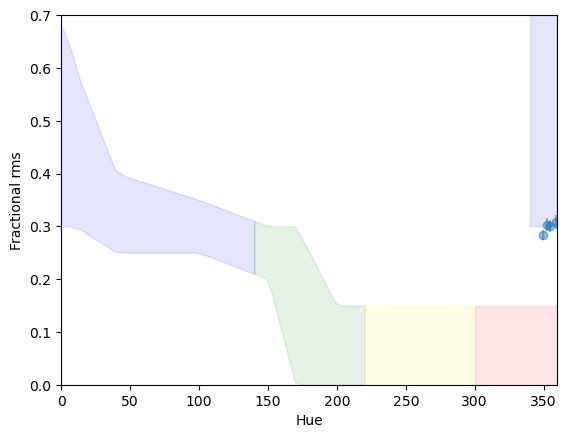

In [29]:
plot_hues(rms, rmse, p1, p2, plot_spans=True, configuration=configuration)

Another way to visualize the spectral state from the rms and hue together is by using a polar plot (here, intuitively, the radius is the rms and the hue is the angle):

<PolarAxes: >

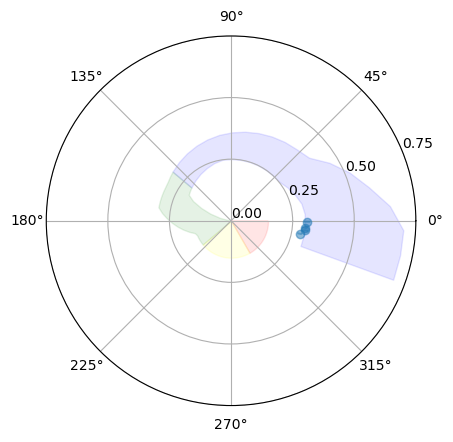

In [30]:
plot_hues(rms, rmse, p1, p2, polar=True, plot_spans=True, configuration=configuration)

## Lags and coherence

With the cross spectrum we can explore the time lags versus frequency

In [31]:
# Use shorter segments, rebin a little more heavily
cs = AveragedCrossspectrum.from_events(events_sub, events_ref, segment_size=2, dt=dt, norm=norm)
cs_reb = cs.rebin_log(0.04)



2696it [00:00, 2806.73it/s]


[]

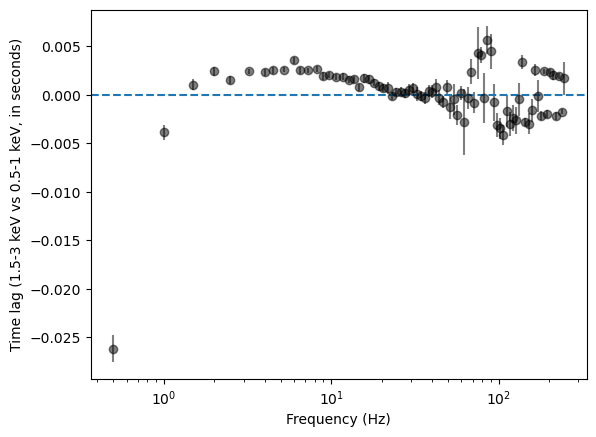

In [32]:
lag, lag_e = cs_reb.time_lag()
plt.figure()
plt.errorbar(cs_reb.freq, lag, yerr=lag_e, fmt="o", color="k", alpha=0.5)
plt.xlabel("Frequency (Hz)")
plt.ylabel(
    f"Time lag ({ref_band[0]:g}-{ref_band[1]:g} keV vs {sub_band[0]:g}-{sub_band[1]:g} keV, in seconds)"
)
plt.axhline(0, ls="--")
plt.semilogx()


Alternatively, we can plot the phase lags:

[]

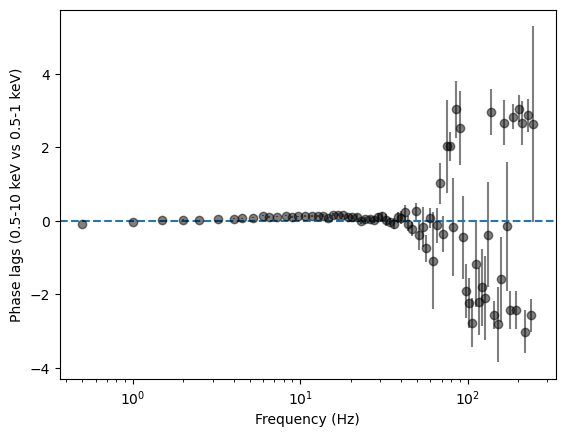

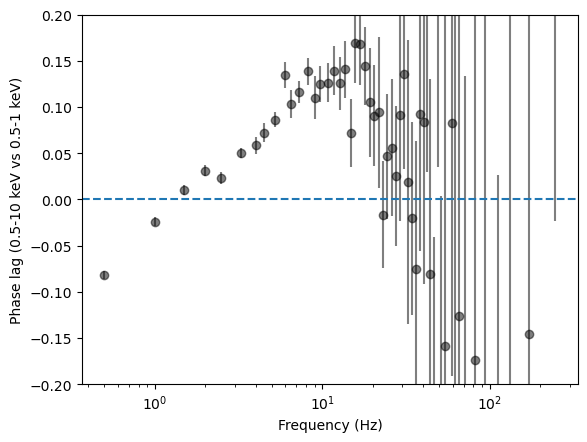

In [33]:
phlag, phlag_e = cs_reb.phase_lag()
plt.figure()
plt.errorbar(cs_reb.freq, phlag, yerr=phlag_e, fmt="o", color="k", alpha=0.5)
plt.xlabel("Frequency (Hz)")
plt.ylabel(
    f"Phase lags ({ref_band[0]:g}-{ref_band[1]:g} keV vs {sub_band[0]:g}-{sub_band[1]:g} keV)"
)
plt.axhline(0, ls="--")
plt.semilogx()

# Zoom in 
plt.figure()
plt.errorbar(cs_reb.freq, phlag, yerr=phlag_e, fmt="o", color="k", alpha=0.5)
plt.xlabel("Frequency (Hz)")
plt.ylabel(
    f"Phase lag ({ref_band[0]:g}-{ref_band[1]:g} keV vs {sub_band[0]:g}-{sub_band[1]:g} keV)"
)
plt.axhline(0, ls="--")
plt.ylim(-0.2, 0.2)
plt.semilogx()


The strange "split" of lags at high frequencies is an artifact that can arise in situations of low coherence and low power in the presence of instrumental effects like deadtime. In this case, with a imaginary part of the quadrature spectrum that is practically 0, the cospectrum has non-zero and even _negative_ values depending on the frequency. The division by 0 in lag calculation produces phase lags at  $\pm180^{\circ}$. This is beyond the scope of this notebook, but we dedicate a notebook to this problem.

Another interesting thing to measure is the coherence at different frequencies. To avoid confusion between different definitions of coherence, Stingray explicitly separates the raw coherence and intrinsic coherence.

[]

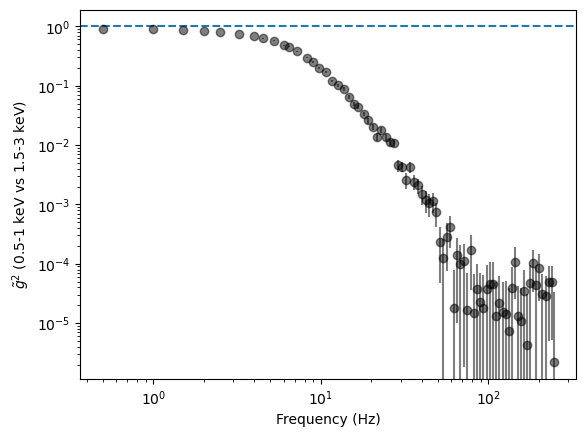

In [34]:
coh, coh_e = cs_reb.raw_coherence()
plt.figure()
plt.errorbar(cs_reb.freq, coh, yerr=coh_e, fmt="o", color="k", alpha=0.5)
plt.xlabel("Frequency (Hz)")
plt.ylabel(
    fr"$\tilde{{g}}^2$ ({sub_band[0]:g}-{sub_band[1]:g} keV vs {ref_band[0]:g}-{ref_band[1]:g} keV)"
)
plt.axhline(1, ls="--")
plt.loglog()


[]

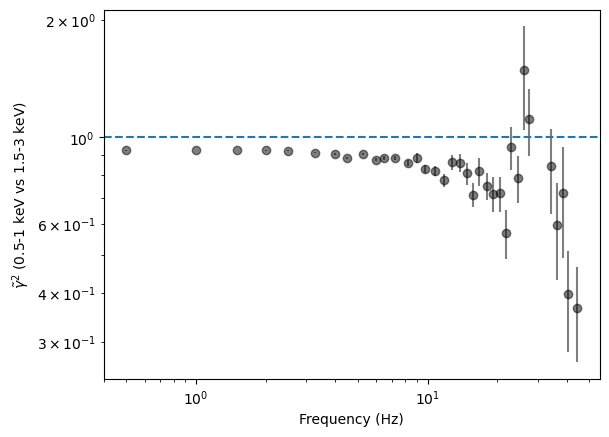

In [35]:
coh, coh_e = cs_reb.intrinsic_coherence()
plt.figure()
plt.errorbar(cs_reb.freq, coh, yerr=coh_e, fmt="o", color="k", alpha=0.5)
plt.xlabel("Frequency (Hz)")
plt.ylabel(
    fr"$\tilde\gamma^2$ ({sub_band[0]:g}-{sub_band[1]:g} keV vs {ref_band[0]:g}-{ref_band[1]:g} keV)"
)
plt.axhline(1, ls="--")
plt.loglog()


Note that the intrinsic coherence is only defined when power on both channels is relatively high (i.e. 3-sigma above noise level in the PDS of both channels). If these conditions are not fulfilled, it is set to NaN as the estimate is generally too noisy to be useful.

Additionally, the calculation of intrinsic coherence has sort of a circular logic, in that the bias term applied to the cross spectrum depends on the intrinsic coherence itself. This can be fixed through an iterative procedure, as suggested by Ingram+2019. This is generally a very small correction, especially when many powers are averaged, and can be applied with `adjust_bias=True`. We show the systematic differences below.

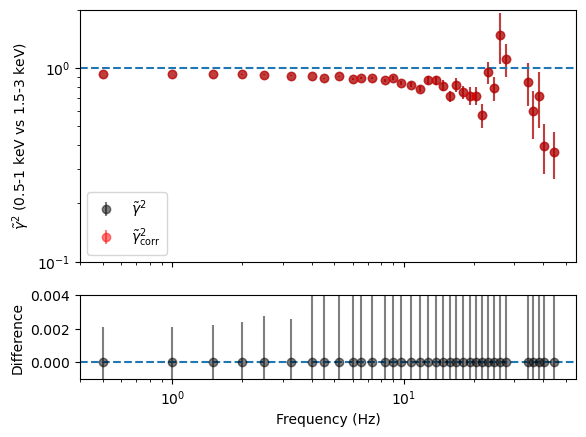

In [36]:
intr_coh, intr_coh_e = cs_reb.intrinsic_coherence()
intr_coh_adj, intr_coh_adj_e = cs_reb.intrinsic_coherence(adjust_bias=True)

fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, height_ratios=(3,1))
ax0.errorbar(cs_reb.freq, intr_coh, yerr=intr_coh_e, fmt="o", color="k", alpha=0.5, label=r"$\tilde\gamma^2$")
ax0.errorbar(cs_reb.freq, intr_coh_adj, yerr=intr_coh_adj_e, fmt="o", color="r", alpha=0.5, label=r"$\tilde\gamma^2_{\rm corr}$")
ax0.set_ylabel(
    fr"$\tilde\gamma^2$ ({sub_band[0]:g}-{sub_band[1]:g} keV vs {ref_band[0]:g}-{ref_band[1]:g} keV)"
)
ax1.errorbar(cs_reb.freq, intr_coh - intr_coh_adj, yerr=intr_coh_e, fmt="o", color="k", alpha=0.5)

ax1.set_ylabel("Difference")
ax1.set_xlabel("Frequency (Hz)")
ax0.axhline(0, ls="--")
ax1.axhline(0, ls="--")
ax0.loglog()
ax0.set_ylim(1e-1, 2)
ax1.set_ylim(-1e-3, 4e-3)
ax0.legend()
ax0.axhline(1, ls="--")


For more advanced calculations, e.g. including customly-fit values for the Poisson noise levels of power spectra, users are encouraged to use the function `stingray.fourier.intrinsic_coherence` with the appropriate inputs.

# Spectral timing

Now let us explore the spectral timing properties of this observation, with no physical interpretation, just for the sake of data exploration.

In [37]:
from stingray.varenergyspectrum import CountSpectrum, CovarianceSpectrum, RmsSpectrum, LagSpectrum

Let us start with the lag spectrum with respect to energy, in different frequency bands.
This might be confusing for people coming from other wavelengths, so let us specify that

+ "frequency" refers to the frequency of the variability.

+ "energy" refers to the photon energy.

The photons at 0.3-12 keV are modulated by oscillations and other stochastic noise up to ~100 Hz (see section above). As an example, we will now analyze the spectral timing properties using the variability up to 1 Hz and between 4 and 10 Hz.

From [Kara et al. 2019](https://www.nature.com/articles/s41586-018-0803-x), figure 3

In [38]:
energy_spec = np.geomspace(0.5, 10, 41)
segment_size = 10
bin_time = 0.001
freq_interval = [3, 30]
ref_band = [0.5, 10]

# If not specified, the reference energy band is the whole band.

lagspec_3_30 = LagSpectrum(
    events,
    freq_interval=freq_interval,
    segment_size=segment_size,
    bin_time=bin_time,
    energy_spec=energy_spec,
    ref_band=ref_band,
)
energies = lagspec_3_30.energy

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:57<00:00,  1.44s/it]


[]

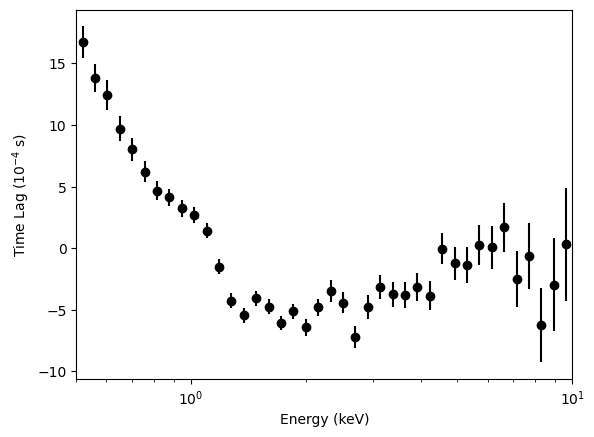

In [39]:
plt.figure()
plt.errorbar(
    energies,
    lagspec_3_30.spectrum * 1e4,
    yerr=lagspec_3_30.spectrum_error * 1e4,
    fmt="o",
    label="3-30 Hz",
    color="k",
)
plt.xlabel("Energy (keV)")
plt.ylabel("Time Lag ($10^{-4}$ s)")
plt.xlim([0.5, 10])
plt.semilogx()

In [40]:
lagspec_01_1 = LagSpectrum(
    events,
    freq_interval=[0.1, 1],
    segment_size=segment_size,
    bin_time=bin_time,
    energy_spec=energy_spec,
    ref_band=ref_band,
)
energies = lagspec_01_1.energy
energies_err = np.diff(lagspec_01_1.energy_intervals, axis=1).flatten() / 2

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:54<00:00,  1.37s/it]


Text(0, 0.5, 'Time lag (s)')

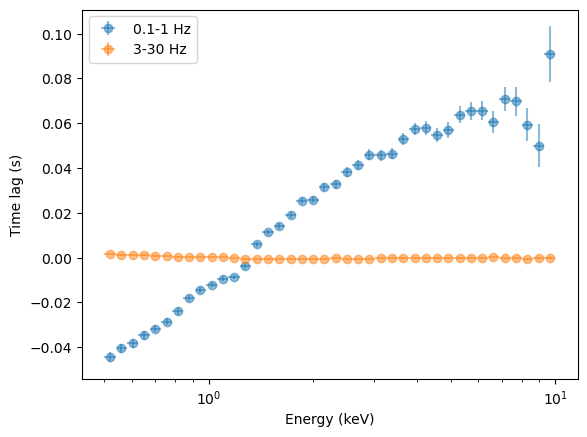

In [41]:
plt.figure()
plt.errorbar(
    energies,
    lagspec_01_1.spectrum,
    xerr=energies_err,
    yerr=lagspec_01_1.spectrum_error,
    fmt="o",
    label="0.1-1 Hz",
    alpha=0.5,
)
plt.errorbar(
    energies,
    lagspec_3_30.spectrum,
    xerr=energies_err,
    yerr=lagspec_3_30.spectrum_error,
    fmt="o",
    label="3-30 Hz",
    alpha=0.5,
)
plt.legend()
plt.semilogx()
plt.xlabel("Energy (keV)")
plt.ylabel("Time lag (s)")

Text(0, 0.5, 'Phase lag (rad)')

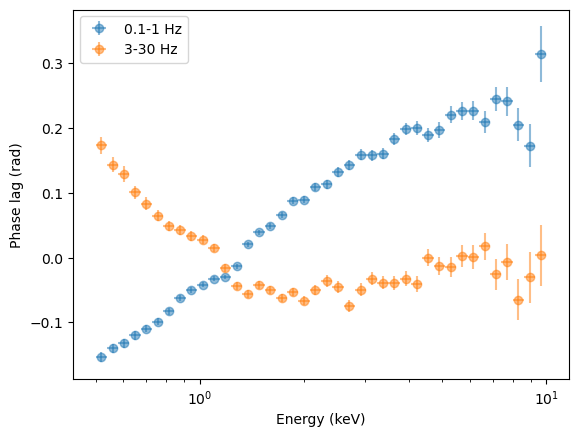

In [42]:
freq_01_1 = (1 + 0.1) / 2 * 2 * np.pi
freq_3_30 = (3 + 30) / 2 * 2 * np.pi
plt.figure()
plt.errorbar(
    energies,
    lagspec_01_1.spectrum * freq_01_1,
    xerr=energies_err,
    yerr=lagspec_01_1.spectrum_error * freq_01_1,
    fmt="o",
    label="0.1-1 Hz",
    alpha=0.5,
)
plt.errorbar(
    energies,
    lagspec_3_30.spectrum * freq_3_30,
    xerr=energies_err,
    yerr=lagspec_3_30.spectrum_error * freq_3_30,
    fmt="o",
    label="3-30 Hz",
    alpha=0.5,
)
plt.legend()
plt.semilogx()
plt.xlabel("Energy (keV)")
plt.ylabel("Phase lag (rad)")

Interesting: the low-frequency variability has much longer time lags than the high-frequency variability, but the phase lags are on the same order of magnitude.

## Covariance and RMS spectrum

In [43]:
covspec_3_30 = CovarianceSpectrum(
    events,
    freq_interval=[3, 30],
    segment_size=segment_size,
    bin_time=bin_time,
    energy_spec=energy_spec,
    norm="abs",
    ref_band=ref_band,
)
covspec_01_1 = CovarianceSpectrum(
    events,
    freq_interval=[0.1, 1],
    segment_size=segment_size,
    bin_time=bin_time,
    energy_spec=energy_spec,
    norm="abs",
    ref_band=ref_band,
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:00<00:00,  1.51s/it]


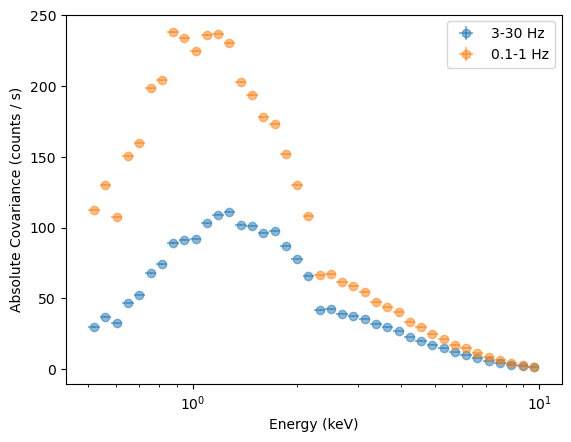

In [44]:
plt.figure()
plt.errorbar(
    energies,
    covspec_3_30.spectrum,
    xerr=energies_err,
    yerr=covspec_3_30.spectrum_error,
    fmt="o",
    label="3-30 Hz",
    alpha=0.5,
)
plt.errorbar(
    energies,
    covspec_01_1.spectrum,
    xerr=energies_err,
    yerr=covspec_01_1.spectrum_error,
    fmt="o",
    label="0.1-1 Hz",
    alpha=0.5,
)
plt.legend()
plt.semilogx()
plt.xlabel("Energy (keV)")
plt.ylabel("Absolute Covariance (counts / s)");

This covariance, plotted this way, mostly tracks the number of counts in each energy bin. To get an unfolded covariance, we need to use the response of the instrument. Another way is to plot the fractional covariance, normalizing by the number of counts in each bin.

To do this, we calculate the Count Spectrum and divide by it.

In [45]:
countsp = CountSpectrum(events, energy_spec=energy_spec)

40it [00:07,  5.66it/s]


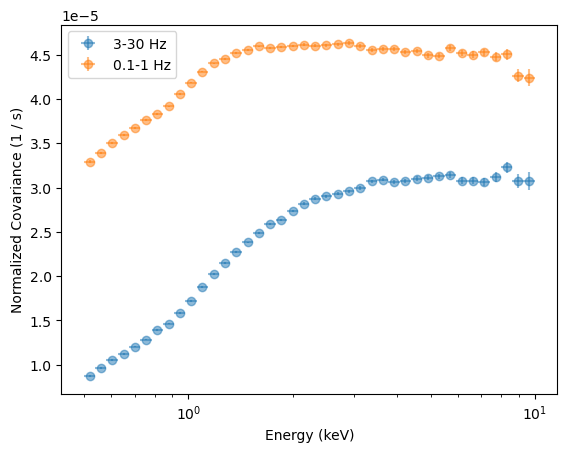

In [46]:
plt.figure()
plt.errorbar(
    energies,
    covspec_3_30.spectrum / countsp.spectrum,
    xerr=energies_err,
    yerr=covspec_3_30.spectrum_error / countsp.spectrum,
    fmt="o",
    label="3-30 Hz",
    alpha=0.5,
)
plt.errorbar(
    energies,
    covspec_01_1.spectrum / countsp.spectrum,
    xerr=energies_err,
    yerr=covspec_01_1.spectrum_error / countsp.spectrum,
    fmt="o",
    label="0.1-1 Hz",
    alpha=0.5,
)
plt.legend()
plt.semilogx()
plt.xlabel("Energy (keV)")
plt.ylabel("Normalized Covariance (1 / s)");

Alternatively, we can calculate the Covariance Spectrum in fractional rms normalization

In [47]:
covspec_01_1 = CovarianceSpectrum(
    events,
    freq_interval=[0.1, 1],
    segment_size=segment_size,
    bin_time=bin_time,
    energy_spec=energy_spec,
    norm="frac",
)
covspec_3_30 = CovarianceSpectrum(
    events,
    freq_interval=[3, 30],
    segment_size=segment_size,
    bin_time=bin_time,
    energy_spec=energy_spec,
    norm="frac",
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:04<00:00,  1.62s/it]


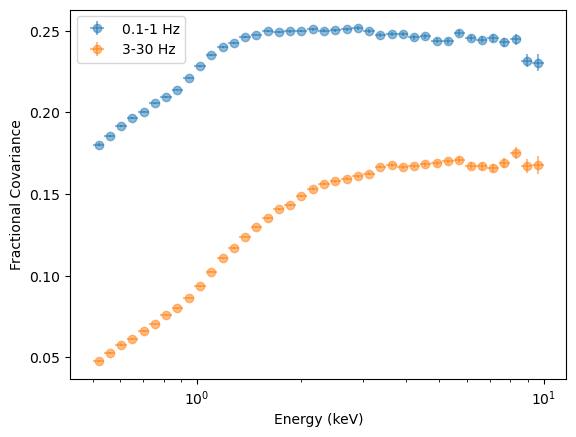

In [48]:
plt.figure()
plt.errorbar(
    energies,
    covspec_01_1.spectrum,
    xerr=energies_err,
    yerr=covspec_01_1.spectrum_error,
    fmt="o",
    label="0.1-1 Hz",
    alpha=0.5,
)
plt.errorbar(
    energies,
    covspec_3_30.spectrum,
    xerr=energies_err,
    yerr=covspec_3_30.spectrum_error,
    fmt="o",
    label="3-30 Hz",
    alpha=0.5,
)
plt.legend()
plt.semilogx()
plt.xlabel("Energy (keV)")
plt.ylabel("Fractional Covariance");

This should largely be equivalent to the RMS spectrum

In [49]:
rmsspec_01_1 = RmsSpectrum(
    events,
    freq_interval=[0.1, 1],
    segment_size=segment_size,
    bin_time=bin_time,
    energy_spec=energy_spec,
    norm="frac",
)
rmsspec_3_30 = RmsSpectrum(
    events,
    freq_interval=[3, 30],
    segment_size=segment_size,
    bin_time=bin_time,
    energy_spec=energy_spec,
    norm="frac",
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.51it/s]


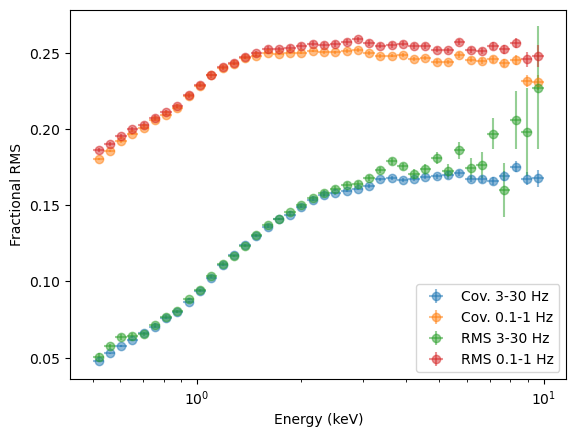

In [50]:
plt.figure()
plt.errorbar(
    energies,
    covspec_3_30.spectrum,
    xerr=energies_err,
    yerr=covspec_3_30.spectrum_error,
    fmt="o",
    label="Cov. 3-30 Hz",
    alpha=0.5,
)
plt.errorbar(
    energies,
    covspec_01_1.spectrum,
    xerr=energies_err,
    yerr=covspec_01_1.spectrum_error,
    fmt="o",
    label="Cov. 0.1-1 Hz",
    alpha=0.5,
)
plt.errorbar(
    energies,
    rmsspec_3_30.spectrum,
    xerr=energies_err,
    yerr=rmsspec_3_30.spectrum_error,
    fmt="o",
    label="RMS 3-30 Hz",
    alpha=0.5,
)
plt.errorbar(
    energies,
    rmsspec_01_1.spectrum,
    xerr=energies_err,
    yerr=rmsspec_01_1.spectrum_error,
    fmt="o",
    label="RMS 0.1-1 Hz",
    alpha=0.5,
)
plt.legend()
plt.semilogx()
plt.xlabel("Energy (keV)")
plt.ylabel("Fractional RMS");

QED, except that the error bars in some points look underestimated. It is always recommended to test error bars with simulations, in any case, as analytic formulas are based on a series of assumptions (in particular, on the coherence) that might not be correct in real life.

In [51]:
from stingray.varenergyspectrum import LagSpectrum

covspec_3_30 = CovarianceSpectrum(
    events,
    freq_interval=[3, 30],
    segment_size=segment_size,
    bin_time=bin_time,
    energy_spec=energy_spec,
    norm="frac",
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:59<00:00,  1.49s/it]


# Saving for further analysis with Xspec

Both frequency and energy spectra can be saved through their `save_as_xspec` methods. They need HEASOFT to be installed, so that the `ftflx2xsp` tool can be used.

Note: they don't apply any of the corrections that mission pipelines can apply. In particular, count spectra will probably need to be rescaled. Also, whilst the frequency spectra just need the flat response that ``flx2xsp`` produces by default, variability-energy spectra will probably need a change of the `RESPFILE`, `ANCRFILE`, `BACKFILE` keywords to point to responses and auxiliary files produced by the pipeline. This can be done through the `header_keywords` keyword argument. See example below.

E.g.

In [52]:
cs.save_as_xspec(outroot="cs")
covspec_3_30.save_as_xspec(outroot="covspec_3_30", header_keywords={"RESPFILE": "my_response.rmf", "ANCRFILE": "my_arf.arf"})

In [53]:
!ls *.pha *.rsp

covspec_3_30.pha cs_imag.pha      cs_real.pha
covspec_3_30.rsp cs_imag.rsp      cs_real.rsp
